# Tutorial

In this Jupyter notebook, we will do a walkthrough of using PyFDAM to fit a mock impedance data and using it to validate a galvanostatic discharge data. Before you run this tutorial, make sure you've installed PyFDAM!

First, let's import the library. We will also import `numpy` as it will be useful later on.

In [1]:
import pyfdam
import numpy as np

Next, we'll define the **model** and its **parameters**. In PyFDAM, a model is a formula $ Z(s) $ for the impedance data, where $ s $ is the frequency argument. In Python, the model is written as a function followed by parameters as an additional argument:

```python
def Zmodel(s,parameters):
    # Define your model which takes in 'parameters' as argument
```

The argument ` parameters ` cannot be defined/managed arbitrarily! PyFDAM provides an object called ` Params ` that will manage the parameters, how they're labeled, and whether they should be designated as fitting vs. fixed parameters. 


For this tutorial, our model is defined as a symmetric cell with a porous electrode of thickness $ L $ and specific interfacial area $ a$. The contact surface area of the cell is denoted as $A$. Also, the electrolyte's conductivity is denoted by $ \kappa $ and the current collector's conductivity is denoted by $ \sigma $. The cell is connected to an external resistor $ R_\mathrm{ext} $, which model's separator resistance + other external resistance contributions, as well as an inductance element $ L_\mathrm{ind} $ in series.  Finally, double layer capacitance at the electrode/electrolyte interface is modelled as a simple capacitance $ C_\mathrm{dl} $.

In total we have 8 parameters ($ L, a, A, \kappa, \sigma, R_\mathrm{ext}, L_\mathrm{ind}, C_\mathrm{dl} $). For this tutorial, we assume that $ L, a, A, \sigma $ will be known and is therefore fixed while the rest will be treated as fitting parameters. To do this, we will create the `Params` object and add a list of parameters to it

In [2]:
#Step 1 -  Define the Parameters List
myparams = pyfdam.Params()

#Step 2 - Write the fixed parameters
#Electrode thickness (cm)
myparams.add('L',0.0242,vary=False)
#Conducitivity of current collector
myparams.add('sig',8,vary=False)
#The interfacial area (cm^2/cm^3)
myparams.add('a',6*10**6,vary=False)
#The cell area (cm^2).
myparams.add('A',71.43,vary=False)

#Step 3 - 
#Seperator/solution resistance, (ohm)
myparams.add('Rext',1.0,vary=True,min=0)
#External inductance (F/cm2)
myparams.add('Lind',1e-5,vary=True,min=0)
#double layer capacitance (F/cm2)
myparams.add('Cdl',1e-5,vary=True,min=0)
#Conductivity of electrolyte
myparams.add('kap',1.0,vary=True,min=0)

Note that each parameter can be accessed via `.value` method:

In [3]:
#As an example, we can print the conducitivity of the electrolyte
print(myparams['kap'].value)

#Or print the electrode thickness 
print(myparams['L'].value)

1.0
0.0242


Once the parameters have been defined, we can actually write the model's function. Let $ Z(s) $ be the cell's total impedance, then the equation for the $ Z(s) $ can be written as

\begin{gather}
Z(s) = \frac{2 L}{(\kappa + \sigma)} \left[1+\frac{2+\left(\frac{\kappa}{\sigma}+\frac{\sigma}{\kappa}\right)\cosh \nu}{\nu \sinh \nu}\right] +R_\mathrm{ext} +s \cdot L_\mathrm{ind}
\\
\nu = \sqrt{a \left(s \cdot C_\mathrm{dl} \right) L^2 \left(\frac{1}{\kappa}+\frac{1}{\sigma}\right)}
\end{gather}
where the first term is the porous electrode contribution.

The corresponding Python function is

In [4]:
def Zmodel(s, params):
    #Access the raw numbers from the Params object
    Rext = params['Rext'].value
    Cdl = params['Cdl'].value
    Lind = params['Lind'].value
    K = params['kap'].value
    sig = params['sig'].value
    L = params['L'].value
    a = params['a'].value
    A = params['A'].value
    
    res = Cdl*s
    nu = (a*res*L**2*(1/sig+1/K))**0.5
    imp = (1+(2+(sig/K+K/sig)*np.cosh(nu))/(nu*np.sinh(nu)))

    return (2*L*imp/(A*(K+sig))+Rext+Lind*(s))

Once we've defined the parameters and model, we can now use them to do impedance fitting. To do this we construct an `ImpedanceFitter` object that will take our defined model, parameters, and impedance data filename as an input.


In [5]:
MyFit = pyfdam.ImpedanceFitter(model=Zmodel,parameters=myparams,namedata="EIS_Mock_Data.txt")

Note that the datafile must be formatted with three columns and no headers! The first column is frequency, the second column is the real part of the impedance, and the third column is the imaginary part of the impedance. In this tutorial, the experimental data is `EIS_Com_2V.txt` so check that file for reference!. 

Finally, we can run the fitting process using the `.run()` method. The fitting run is done by selecting a suitable numerical method as an initial error minimization step. This is then followed by some number of cycles, denoted by `ncycles`, of Leveberg-Marquadt algorithm to further converge the parameters and obtain their uncertainty.

In [6]:
MyFit.run(method='nelder',ncycles=1) #In here, we've chosen Nelder-Mead ad the initial method

[[Variables]]
    L:     0.0242 (fixed)
    sig:   8 (fixed)
    a:     6000000 (fixed)
    A:     71.43 (fixed)
    Rext:  0.01531600 +/- 1.1009e-04 (0.72%) (init = 0.02352427)
    Lind:  4.8185e-06 +/- 1.6489e-07 (3.42%) (init = 3.985611e-06)
    Cdl:   7.6876e-06 +/- 7.8261e-09 (0.10%) (init = 7.660804e-06)
    kap:   0.01425053 +/- 1.6015e-04 (1.12%) (init = 3.835463)
[[Correlations]] (unreported correlations are < 0.100)
    C(Rext, kap) =  0.690


A list of numerical methods for the initial fitting can be found in [the LMFIT package's documentation](https://lmfit.github.io/lmfit-py/fitting.html).

Next, we can take a look at the result of the fitting. To do this, we need to grab the output result as well as the experimental impedance data.

In [7]:
#Get both the frequency (expfreq) and impedance data (expdata) of from the loaded textfile!
expfreq, expdata = MyFit.get_impedanceexp()

#Get the impedance output from the model using .get_impedancemodel() method. It takes a list of frequencies as an argument
modeldata = MyFit.get_impedancemodel(expfreq)

Afterwards, we can plot the data!

(0.0, 0.07)

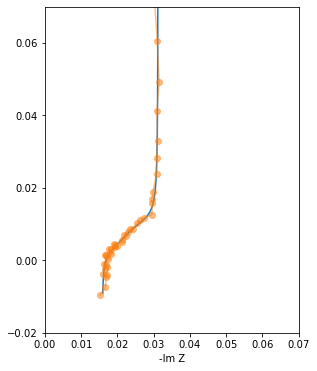

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
#Plotting model data
plt.plot(modeldata.real,-modeldata.imag)

#Plotting experimental data
plt.plot(expdata.real,-expdata.imag,'o-',alpha=0.5)

#Impedance plot should be equal axes
plt.gca().set_aspect('equal', adjustable='box')

#Some labelling
plt.xlabel('Re Z')
plt.xlabel('-Im Z')
#Adjust the range as necessarry!
plt.ylim([-0.02,0.07])
plt.xlim([0,0.07])

We can also save the impedance data for later plotting

In [9]:
#We use the list of frequencies from the experimental data, although we could use any other list of frequencies
MyFit.save_impedance(expfreq,'EIS_Model_Data.txt')

What's next? Well we can use this set of parameters to run a discharge experiment. The data that we will compare  with starts  at a fully charged cell at 2.4 V, which was discharging at a current of 200 A. To setup the galvanostatic discharge simulation, we need to create a `Galvanostatic` object and feed it wth out model and the fitted parameters, which we can get from the previous `ImpedanceFitter` object via the `.get_params()` method

In [10]:
MyGalvanostatic = pyfdam.Galvanostatic(model=Zmodel,parameters=MyFit.get_params())

To run the simulation, we can use the `.run()` method which will use the Gaver-Stehfest (GV) method to perform numerical inverse Laplace transform. The `.run()` method takes in the following arguments: 
1. `time` ($ t $) is an array of time which starts from **intial time larger than zero** (the GV method cannot handle t=0 which requeires information at infinite frequency) and up to some final time. 
2. `DeltaV0` ($ \Delta V_0 $)the initial total difference in potential across cell
3. `Iapp` ($ I_\mathrm{app} $) is the applied current, with (-)/(+) sign indicating discharging/charging experiments respectively,
4. `A` ($ A $) is an optional parameter that is divided against the impedance function $ Z(s) $ This is used only if the original model is not described in the correct Ohmic units, e.g., the model impedance is multiplied by surface area, etc. By default, it is set to one. For our tutorial,`'A` will be the surface area parameter $ A $ since the original model is expressed in terms of Ohm cm^2. 
5. `Nterms`($ N_\mathrm{terms} $) is a parameter for the Gaver-Stehfest method, which should be around 6 to 20 to obtain good convergence of the time-domain profile. By default, it is set to 10.

Under the hood, the code is inverting the following function in Laplace space:

\begin{equation}
V(s) = \frac{\Delta V_0}{s}+\frac{I_\mathrm{app} Z(s)}{s \cdot A}
\end{equation}

by using the following series expansion:

\begin{gather}
V(t) \approx \Delta V_0+\frac{\ln 2}{t} \sum_{n=1}^{N_\mathrm{terms}} c_{n} \frac{I_\mathrm{app} t}{A(n \ln 2)} \cdot Z\left(\frac{n \ln 2}{t}\right)
\\
c_{n}=(-1)^{n+\frac{N_\mathrm{terms}}{2}} \sum_{k=\frac{n+1}{2}}^{\min (n, N_\mathrm{terms} / 2)} \frac{k^{N_\mathrm{terms} / 2}(2 k) !}{(N_\mathrm{terms} / 2-k) ! k !(k-1) !(n-k) !(2 k-n) !}
\end{gather}

PyFDAM automates the whole series expansion computation so all we need to do is just feed in the right parameters!

In [11]:
#Load the discharge data
expdata = np.loadtxt("Discharge_Mock_Data.txt")
#The time array is obtained from the mock data. Note that we also exclude the initial time!
MyGalvanostatic.run(time = expdata[1:,0], V0=2.4,Iapp=-200,A=myparams['A'].value)


Similar to the impedance run, we can get the data, which is done through the `.get_output()` method, save the data, which is done through the `.save_output` method, and plot the results

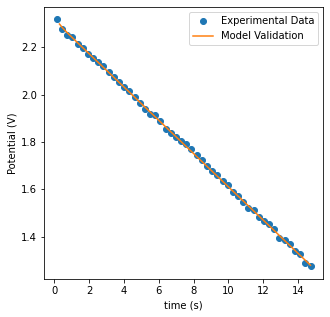

In [12]:
#Grabbing the output as well as time used
t, modeldata = MyGalvanostatic.get_output()
#Saving the output
MyGalvanostatic.save_output("Discharge_Data_Results.txt")

plt.figure(figsize=(5,5))
plt.plot(expdata[::2,0],expdata[::2,1],'o', label="Experimental Data")
plt.plot(t,modeldata,label="Model Validation")
plt.xlabel("time (s)")
plt.ylabel("Potential (V)")
plt.legend(loc=0)
plt.show()

## Extra Notes

The module only consists of one file, which is just an `__init__.py` file. All codes are implemented in there. PyFDAM also do not implement the fitting routines by itself, and delegate it to the LMFIT package. Any issues pertaining to the fitting process can be traced directly to the LMFIT package. I highly recommend looking at LMFIT package for more troubleshooting because non-linear curve fitting, just by the nature of the mathematical problem, can be difficult! 